<a href="https://colab.research.google.com/github/NinLev/dotfiles/blob/master/cifar_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR Classification

### Exercise objectives

- Implement a CNN for a 10-class classification problem
- Enhance the CNN performance with data augmentation techniques
- Experiment the acceleration of GPU for image processing (Google Colab)

<hr>
<hr>

You should now have a better feeling of how a CNN is working, and especially how the convolutions are affecting the image to detect specific features. Therefore, let's now play with a bit more complex images. 

The CIFAR-10 dataset is a dataset that contains images of 10 different classes 

<img src="https://people.minesparis.psl.eu/fabien.moutarde/ES_MachineLearning/mini-projets/cifar10_notebook_fichiers/cifar_10.png">

This dataset is emblematic in the research community as many enhancements for image problems have been achieved on this dataset, and later on the CIFAR-100 dataset once the performance got too high. You can check the [wikipedia](https://en.wikipedia.org/wiki/CIFAR-10) page of the dataset if you want to know more about it.

In this notebook, we propose to implement a CNN to distinguish the 10 categories from the CIFAR-10 dataset. Again, remember that until 10 years ago, this problem was very challenging to the entire research community and is now for you to tackle.


## 0. Colab

**First, make sure to use GPU acceleration** by clicking on `"Runtime --> Change runtime --> GPU"` if you are on Colab. 

## 1. Data

We'll take care of data loading and preprocessing for you. Just run the following cells and make sure you understand them

In [1]:
from tensorflow.keras.datasets import cifar10
import numpy as np

(images_train, labels_train), (images_test, labels_test) = cifar10.load_data()
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print(images_train.shape, images_test.shape)
unique, counts = np.unique(labels_train, return_counts=True)
dict(zip(unique, counts))

(50000, 32, 32, 3) (10000, 32, 32, 3)


{0: 5000,
 1: 5000,
 2: 5000,
 3: 5000,
 4: 5000,
 5: 5000,
 6: 5000,
 7: 5000,
 8: 5000,
 9: 5000}

❗️ 50,000 images may take a long time to train: **Always start with a subsample to iterate quickly** before scaling up

Below, we divide the dataset size by `reduction_factor=10`. Don't try to increase it unless we ask you too.

In [2]:
# Reduce size
reduction_factor = 10

idx_train =  np.random.choice(len(images_train), round(len(images_train)/reduction_factor))
idx_test =  np.random.choice(len(images_test), round(len(images_test)/reduction_factor))

images_train_small = images_train[idx_train]
images_test_small = images_test[idx_test]
labels_train_small = labels_train[idx_train]
labels_test_small = labels_test[idx_test]

print(images_train.shape, images_test.shape)
unique, counts = np.unique(labels_train_small, return_counts=True)
dict(zip(unique, counts))

(50000, 32, 32, 3) (10000, 32, 32, 3)


{0: 467,
 1: 503,
 2: 502,
 3: 508,
 4: 492,
 5: 508,
 6: 525,
 7: 506,
 8: 467,
 9: 522}

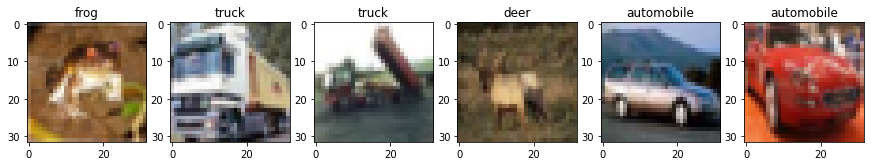

In [3]:
# Let's plot few images to see what they look like
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
for i in range(6):
    plt.subplot(1,6, i+1)
    img = images_train[i]
    label = labels_train[i][0]
    plt.imshow(img)
    plt.title(labels[label])

And, as usual,
- we normalize the data between 0 and 1
- we create `y` as one-hot-encoded version of `labels`

In [4]:
X_train = images_train / 255.
X_train_small = images_train_small / 255.
X_test = images_test / 255.
X_test_small = images_test_small / 255.

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(labels_train, 10)
y_train_small = to_categorical(labels_train_small, 10)
y_test = to_categorical(labels_test, 10)
y_test_small = to_categorical(labels_test_small, 10)

In [5]:
y_train_small.shape

(5000, 10)

In [6]:
y_test_small.shape

(1000, 10)

## 2. Iterate on your CNN architecture using your small training set


❓ **Question** ❓ Your turn to shine!

- Define the CNN architecture of your choice in a method `initialize_model()`
- Compile your model in a method `compile_model()`:
- Fit it on your **small** training set **only**
- Store the output of the fit in an `history` variable
- Try a first model yourself, before looking at PRO TIPS below
 
<details>
    <summary> 🆘 PRO TIPS 🆘  </summary>


- Do not forget to add the input shape of your data to the first layer: it has 3 colors
- Start simple, complexify after few trials to get better results
- The task is complex: Try at least 3 or 4 convolutions
- Kernel size do not need to be large for such small picture resolution!
- Add some Maxpooling (but not too much else the activation "image" will become too small)
- Keep padding = 'same' and 'stride' = (1,1) to start with.
- Once your model overfits, try adding some dropout layer to regularize the network. A good tip is too increase dropout strengh as you move closer to the output, so as not to overfit on your end-result
- Images are so small, that you can use larger batch size (32 or 64) to benefit from even more GPU parallelization
</details>


In [7]:
from tensorflow.keras import layers
from tensorflow.keras import models

In [8]:
def initialize_model():
    '''instanciate and return the CNN architecture of your choice with less than 150,000 params'''
    
    model = models.Sequential()
    
    model.add(layers.Conv2D(32,(3,3), strides=(1,1),input_shape=(32, 32, 3), padding = 'same', activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))

    ### Second convolution & max-pooling
    model.add(layers.Conv2D(64, (3,3), padding = 'same', activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))

    model.add(layers.Conv2D(32, (3,3), padding = 'same', activation="relu"))
    #model.add(layers.MaxPooling2D(pool_size=(2,2)))

    model.add(layers.Conv2D(32, (3,3), activation="relu"))
    #model.add(layers.MaxPooling2D(pool_size=(2,2)))
    
    ### Flattening
    model.add(layers.Flatten())
    
    ### One fully connected
    model.add(layers.Dense(100, activation='relu'))
    
    model.add(layers.Dropout(0.4))

    ### Last layer
    model.add(layers.Dense(10, activation='softmax'))

    return model

In [9]:
def initialize_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    #model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    #model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(128, (2, 2), activation='relu', padding='same'))
    #model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.Dropout(0.3))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(10, activation='softmax'))
    return model

In [10]:
def compile_model(model):
    '''return a compiled model suited for the cifar tasks'''
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

    return model

In [11]:
model = initialize_model()

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         3

In [13]:
compile_model(model)

In [26]:
history = model.fit(X_train_small, y_train_small, validation_data = (X_test_small, y_test_small), epochs = 500, batch_size = 32, verbose = 1)

Epoch 1/500
157/157 [==============================] - 1s 6ms/step - loss: 0.3616 - accuracy: 0.8770 - val_loss: 1.3870 - val_accuracy: 0.6120
Epoch 2/500
157/157 [==============================] - 1s 5ms/step - loss: 0.3580 - accuracy: 0.8702 - val_loss: 1.4459 - val_accuracy: 0.6170
Epoch 3/500
157/157 [==============================] - 1s 5ms/step - loss: 0.3693 - accuracy: 0.8632 - val_loss: 1.4697 - val_accuracy: 0.6010
Epoch 4/500
157/157 [==============================] - 1s 5ms/step - loss: 0.3625 - accuracy: 0.8680 - val_loss: 1.5020 - val_accuracy: 0.6090
Epoch 5/500
157/157 [==============================] - 1s 5ms/step - loss: 0.3722 - accuracy: 0.8696 - val_loss: 1.5038 - val_accuracy: 0.6170
Epoch 6/500
157/157 [==============================] - 1s 5ms/step - loss: 0.3213 - accuracy: 0.8846 - val_loss: 1.4459 - val_accuracy: 0.6180
Epoch 7/500
157/157 [==============================] - 1s 5ms/step - loss: 0.3450 - accuracy: 0.8772 - val_loss: 1.5286 - val_accuracy: 0.6030

KeyboardInterrupt: ignored

In [27]:
history.history['loss']

[2.214280366897583,
 1.9326070547103882,
 1.7934677600860596,
 1.6837228536605835,
 1.6226603984832764,
 1.5715692043304443,
 1.534558653831482,
 1.4591823816299438,
 1.416609525680542,
 1.359880805015564,
 1.3242580890655518,
 1.3046398162841797,
 1.255016803741455,
 1.2316296100616455,
 1.1909394264221191,
 1.156951904296875,
 1.1394253969192505,
 1.0917081832885742,
 1.0735435485839844,
 1.0456113815307617,
 1.0275452136993408,
 1.0334696769714355,
 0.9844216704368591,
 0.9627681374549866,
 0.925784170627594,
 0.9186210036277771,
 0.8945505023002625,
 0.8887791037559509,
 0.8470569252967834,
 0.839529812335968,
 0.8395275473594666,
 0.7914660573005676,
 0.7858813405036926,
 0.7683588862419128,
 0.7638227343559265,
 0.7296891212463379,
 0.7292983531951904,
 0.7158567309379578,
 0.7119841575622559,
 0.6955416798591614,
 0.6866500973701477,
 0.6374523639678955,
 0.6450610160827637,
 0.6383510231971741,
 0.6441854238510132,
 0.6398721933364868,
 0.6065850257873535,
 0.606757402420044,
 

In [28]:
model.evaluate(X_test_small, y_test_small, batch_size=32, verbose=0)

[1.8800930976867676, 0.6259999871253967]

❓ **Question** ❓ Run the following function on the previous history (keep the default arguments, these are intended for future plots in the notebook).

In [29]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

❓ **Question** ❓ Evaluate your model on the test data and compare it with baseline. Are you satisfied with these performances ? Look at PRO TIPS above and iterate a bit if you want to improve!

In [30]:
history.history;

(<matplotlib.axes._subplots.AxesSubplot at 0x7f64b876bb50>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f64b870f290>)

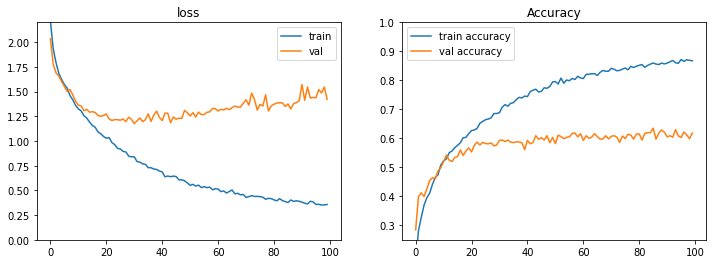

In [31]:
plot_history(history, title='', axs=None, exp_name="")

## 3. Increase data size

❓ **Question** ❓ Now that your model fits on a small subsample, try to fit it on the full dataset and notice how performance increases. 

🚨 **Make sure to use GPU acceleration** by clicking on `"Runtime --> Change runtime --> GPU"` if you are on Colab. 

💡 Training neural network on images (in each batch) can be parallelized, and this parallelization procedure can be done on GPU.


In [33]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 50, batch_size = 32, verbose = 1)

Epoch 1/50
1563/1563 [==============================] - 7s 5ms/step - loss: 1.1152 - accuracy: 0.6168 - val_loss: 0.9572 - val_accuracy: 0.6687
Epoch 2/50
1563/1563 [==============================] - 7s 4ms/step - loss: 1.0420 - accuracy: 0.6414 - val_loss: 0.9229 - val_accuracy: 0.6842
Epoch 3/50
1563/1563 [==============================] - 7s 4ms/step - loss: 0.9963 - accuracy: 0.6559 - val_loss: 0.8888 - val_accuracy: 0.6941
Epoch 4/50
1563/1563 [==============================] - 7s 4ms/step - loss: 0.9642 - accuracy: 0.6691 - val_loss: 0.8687 - val_accuracy: 0.6971
Epoch 5/50
1563/1563 [==============================] - 7s 4ms/step - loss: 0.9247 - accuracy: 0.6820 - val_loss: 0.8370 - val_accuracy: 0.7157
Epoch 6/50
1563/1563 [==============================] - 7s 5ms/step - loss: 0.9072 - accuracy: 0.6864 - val_loss: 0.8246 - val_accuracy: 0.7102
Epoch 7/50
1563/1563 [==============================] - 7s 4ms/step - loss: 0.8906 - accuracy: 0.6901 - val_loss: 0.8082 - val_accuracy:

KeyboardInterrupt: ignored

## 4. Data augmentation

☝️ It seems that adding pictures greatly improves model performance! Welcome to the Deep Learning paradigm, where big data does make a difference.

To easily improve the accuracy of a model without much work, we can generate new data: the _data augmentation_. This widely used technique consists in applying little transformation to input images without changing its label, as mirroring, cropping, intensity changes, etc. The improved performance simply results from the Neural network training with more different data.

The natural way to generate these new images is to apply some transformations and train the model on the original and new images. However, such procedure requires to keep all these images in memory : it can be very intensive, to the point that your computer memory cannot hold any new image (your computer might even crash).

For this reason, we will augment the data **on the fly** (batch per batch), meaning that we will create new data, use them to fit the model, then delete them. Here, Keras is our friend as it provides the utils to do all this job for us. Look at the following code : the general writing can seem odd but don't be panicked: just look at the function arguments that defines the augmentation techniques that we will use and that you can check in the  [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=(0.8, 1.2),
    ) 

datagen.fit(X_train)
datagen

In [ ]:
X_augmented_iterator = datagen.flow(X_train, shuffle=False, batch_size=1)
X_augmented_iterator

💡 Always visualize your data augmentation in order to double check that you can still recognize the label yourself!

In [ ]:
import numpy as np

for i, (raw_image, augmented_image) in enumerate(zip(X_train, X_augmented_iterator)):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2))
    ax1.imshow(raw_image)
    ax2.imshow(augmented_image[0])
    plt.show()
    
    if i > 10:
        break

❗ **Remark** ❗ In this example, there is one augmented image per initial image. In fact, when your model will use `datagen.flow` in the `fit`, it will create one augmentation per epochs! Indeed, the images in the original dataset will not be provided to the optimizer, only augmented ones instead. (But because the augmentations are performed randomly, this allows both modified images and some very close of the originals).

❓ **Question** ❓ Take time to understand the cell below: Previously, we used the `validation_split` argument to let the model separate a training set from the validation one. It is not possible here as **using an image in the training set and its transformation in the validation set is considered as a data leakage**. Therefore, we have to manually define the `validation_data` with the following commands:


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# The model
model_aug = initialize_model()
model_aug = compile_model(model_aug)

# The data generator
X_tr = X_train[:40000]
y_tr = y_train[:40000]
X_val = X_train[40000:]
y_val = y_train[40000:]
train_flow = datagen.flow(X_tr, y_tr, batch_size=64)

# The early stopping criterion
es = EarlyStopping(patience=3)

# The fit
history_aug = model_aug.fit(train_flow, 
                        epochs=50, 
                        callbacks=[es], 
                        validation_data=(X_val, y_val))


❗️❗️ Remark ❗️❗️: The training can be quite long here. Don't hesitate to go to the next exercise and gome back once in a while to finish the last questions

❓ **Question** ❓ Now, let's plot the previous and current run histories. What do you think of the data augmentation?


In [25]:
# YOUR CODE HERE

💡 Data augmentation may not improve your performance easily. It strongly depends on the model architecture you used, the learning rate, the type of augmentation chosen, etc...Image classification is an art that takes lots of practice to master!

🚨 **Don't spend too much time now trying to finetune your model - you have other interesting challenge ahead**. 

📚 [here is a good example of solution for future reference](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/). They manage to get about 80% accuracy

### 🏁 Congratulation 🏁 
Copy this notebook from your google drive into your local data-challenge repo, and commit+push your progress on github. To find where this Colab notebook has been save, click on `File --> Locate in Drive`.